<a href="https://colab.research.google.com/github/aryanarke2003/data-analysis/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Setup and Data Loading

In [12]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [24]:
# Paths to sample CSVs (ensure your working directory contains these files)
data_dir = './8451_The_Complete_Journey_2_Sample-2-1/8451_The_Complete_Journey_2_Sample-2'  # adjust if needed
households = pd.read_csv(f"{data_dir}/400_households.csv")
products = pd.read_csv(f"{data_dir}/400_products.csv")
transactions = pd.read_csv(f"{data_dir}/400_transactions.csv")

In [25]:
# Quick look
print("Households:", households.shape)
print("Products:", products.shape)
print("Transactions:", transactions.shape)

Households: (400, 9)
Products: (67284, 5)
Transactions: (922008, 9)


In [26]:
# Preprocessing and cleaning data
# Replace NaN values in CHILDREN with 0
households['CHILDREN'] = households['CHILDREN'].fillna(0)
# Convert '3+' in CHILDREN to 3 or a higher value if desired
households['CHILDREN'] = households['CHILDREN'].replace('3+', 3)  # You can replace 3 with a higher number if needed
households['CHILDREN'] = households['CHILDREN'].astype(int)

# Remove extra spaces from column names
households.columns = households.columns.str.strip()
products.columns = products.columns.str.strip()
transactions.columns = transactions.columns.str.strip()

# One-hot encoding for categorical variables
categorical_features = ['AGE_RANGE', 'MARITAL', 'INCOME_RANGE', 'HOMEOWNER', 'HH_SIZE', 'HSHD_COMPOSITION']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)],
                                remainder="passthrough")



## 3. Sample Data Pull for Household #10

In [27]:
# Fit the transformer object
transformer.fit(households[categorical_features])
transformed_X = transformer.fit_transform(households[categorical_features])

# Merging the data
# Assuming that customer engagement can be represented by the number of transactions
transactions['COUNT'] = 1
# Aggregate transaction counts by 'HSHD_NUM'
transaction_counts = transactions.groupby('HSHD_NUM').size().reset_index(name='COUNT')
# Merge the data
households = households.merge(transaction_counts, on='HSHD_NUM', how='left')
households['COUNT'].fillna(0, inplace=True)

C:\Users\daksh\AppData\Local\Temp\ipykernel_40884\1325626060.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  households['COUNT'].fillna(0, inplace=True)


In [28]:
# Preparing the data for the regression model
X = transformed_X
y = households['COUNT']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)

# Fit the OneHotEncoder object
one_hot.fit(households[categorical_features])

# Output the coefficients to understand impact
feature_names = one_hot.get_feature_names_out(categorical_features)
print("Feature coefficients:")
for feature, coef in zip(feature_names, model.coef_):
    print(f"{feature}: {coef}")

# Calculate R2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R2 score: {r2}")
print(f"Mean Squared Error: {mse}")

Feature coefficients:
AGE_RANGE_19-24                                                                                                                                                                                                   : 868.5227399139634
AGE_RANGE_25-34                                                                                                                                                                                                   : 72.92123798954893
AGE_RANGE_35-44                                                                                                                                                                                                   : 277.5807816979537
AGE_RANGE_45-54                                                                                                                                                                                                   : -308.2025381496485
AGE_RANGE_55-64                                          

## 4. Exploratory Analysis

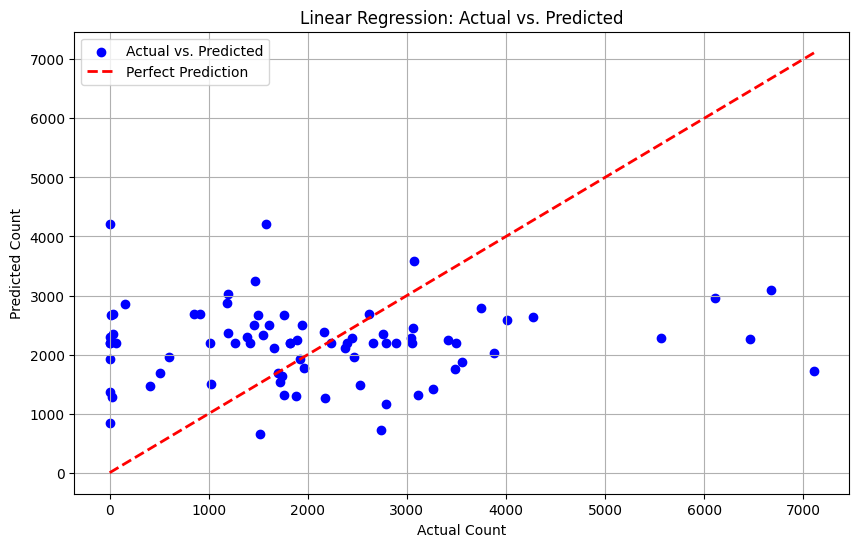

In [29]:
# Predictions on the test set
y_pred = model.predict(X_test)

# Plot the linear regression graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Extract feature coefficients
feature_coefficients = dict(zip(feature_names, model.coef_))

# Sort feature coefficients by absolute magnitude
sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Print top features by absolute coefficient value
print("Top features affecting customer engagement:")
for feature, coef in sorted_coefficients[:2]:  # Extract the top two features
    print(f"{feature}: {coef}")


Top features affecting customer engagement:
HSHD_COMPOSITION_1 Adult and Kids : 1877.649291844491
MARITAL_Single : -1416.0877692309136


In [31]:
# Create a dictionary to store coefficients for each category
category_coefficients = {}

# Iterate through the coefficients and categorize them
for feature, coef in zip(feature_names, model.coef_):
    category = feature.split("_", 1)[0]  # Extract category name from feature name
    if category not in category_coefficients:
        category_coefficients[category] = []
    category_coefficients[category].append(coef)

# Calculate the average coefficient for each category
average_category_coefficients = {category: np.mean(coefs) for category, coefs in category_coefficients.items()}

# Sort categories by average coefficient
sorted_categories = sorted(average_category_coefficients.items(), key=lambda x: x[1], reverse=True)

# Print the categories with positive and negative coefficients
print("Categories with positive coefficients (indicating growth in customer engagement):")
for category, coef in sorted_categories[:5]:  # Assuming you want to see the top 5 growing categories
    print(f"{category}: {coef}")

print("\nCategories with negative coefficients (indicating shrinkage in customer engagement):")
for category, coef in sorted_categories[-5:]:  # Assuming you want to see the top 5 shrinking categories
    print(f"{category}: {coef}")


Categories with positive coefficients (indicating growth in customer engagement):
HSHD: 9.371043623624636e-12
INCOME: 7.308439567818174e-14
AGE: -6.252776074688882e-13
HH: -9.142316533446622e-13
MARITAL: -4.149569576838985e-12

Categories with negative coefficients (indicating shrinkage in customer engagement):
INCOME: 7.308439567818174e-14
AGE: -6.252776074688882e-13
HH: -9.142316533446622e-13
MARITAL: -4.149569576838985e-12
HOMEOWNER: -1.280871704996874e-11
